In [1]:
import warnings
warnings.filterwarnings('ignore')

## Read SDF format data (structured-data format)

Here used a SDF file to save the chemical composition of a molecule

In the SDF file we found 

stored information about position of individual atom

each molecules are delimited by $$$$

the atom block lines start with '    ' and have information about atoms(C,O,N,Cl..)

bond block starts with ' ' and contains info about connection between atoms

In [2]:
import numpy as np
from tqdm.notebook import tqdm   # tqdm is a library in Python which is used for creating Progress Meters or Progress Bars.

# function to read sdf file
def read_sdf(file):
    with open(file, 'r') as rf:  # open the file
        content = rf.read()      # read contents of the file
    samples = content.split('$$$$')  # split the read file by delimiter $$$$ which mean split each molecule in an array
    
    # function to read each molecule ingredient
    def parse_sample(s):
        lines = s.splitlines()  # split data to lines
        links = []              # array for links
        nodes = []              # array for nodes 
        label = 0
        
        #loop over each line
        for l in lines:         
            if l.strip() == '1.0':  
                label = 1
            if l.strip() == '-1.0':
                label = 0
            if l.startswith('    '): # for Atom block 
                feature = l.split()
                node = feature[3]   # features of node (atom) as O,C,N,H .
                nodes.append(node)
            elif l.startswith(' '): # for bond block which tell about connections between atoms (links)
                lnk = l.split()
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):
                    links.append((
                        int(lnk[0])-1, # first atom
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label  # return nodes, links and label
    
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]   # return parse_sample for each molecule   

In [3]:
training_set = read_sdf('train.sdf') # read train dataset (train.sdf) file 

  0%|          | 0/25024 [00:00<?, ?it/s]

In [4]:
testing_set  = read_sdf('test_x.sdf') # read test dataset (test_x.sdf) file

  0%|          | 0/12326 [00:00<?, ?it/s]

# Unbalanced dataset

Here I found that our data is very unbalanced, So we need to make it balance by  upsampling the dataset by simply copying records from minority classes, We can do so via the **resample() method** from the sklearn.utils module

In [5]:
import pandas as pd
train_data = pd.DataFrame(training_set, columns=['node','edge','label']) # convert training_set into DataFrame

0    23806
1     1218
Name: label, dtype: int64


<AxesSubplot:ylabel='label'>

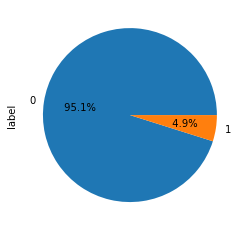

In [6]:
# print number of 0,1 in the label column
print(train_data['label'].value_counts())
train_data.groupby('label').size().plot(kind='pie',label = "label",autopct='%5.1f%%') # pie plot to illustate unbalance data

In [7]:
class0 = train_data[train_data['label']==0] # save train_data['label']=0 into class0 
class1 = train_data[train_data['label']==1] # save train_data['label']=1 into class1

In [8]:
from sklearn.utils import resample 
class1 = resample(class1,replace=True,n_samples=len(class0),random_state=42)  # resample class1

1    23806
0    23806
Name: label, dtype: int64


<AxesSubplot:ylabel='label'>

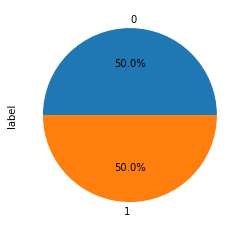

In [9]:
data_upsampled = pd.concat([class1, class0])  # get upsampled data
print(data_upsampled["label"].value_counts()) # print no. of 0, 1 in label column
data_upsampled.groupby('label').size().plot(kind='pie',label = "label",autopct='%1.1f%%') # pie plot to clarify balanced data

In [10]:
# convert data_upsampled from DataFram form to an array form to Visualize data
data_upsampled_ = data_upsampled.to_numpy()

In [11]:
from sklearn.model_selection import train_test_split
training_set, validation_set = train_test_split(data_upsampled_, test_size=0.15,)  # split train data into training & validation

## Visualizing/Inspecting a Sample

Each sample's data is included in the training set (molecule). There are three elements in each sample array. The first part contains textual information on the atoms, the second element contains information about the connections, and the third element contains information about the labels for each molecule.

In [12]:
# import libraries to show network of molecule
!pip install --quiet networkx

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm

colors = cm.rainbow(np.linspace(0, 1, 50))

In [13]:
# function to visualize the compound graph
def visualize(sample):
    G=nx.Graph()
    nodes = sample[0] # atoms are defined as nodes
    edges = sample[1] # connections are defined as edges
    
    labeldict={}    # define dictionary for the nodes
    node_color=[]
    for i,n in enumerate(nodes):  # for each node in the sample
        G.add_node(i)   # add node to the graph each node such as (0,1,2,3, 4..)
        labeldict[i]=n  # building the dictionary  with [key,value] as [0:'N',1:'C']
        node_color.append(colors[hash(n)%len(colors)]) # for color 

    # a list of nodes:
    for e in edges:
        G.add_edge(e[0], e[1])  # add egdes (connections) to the graph from one connection to other connection

    # draw the graph with labels for nodes (atoms) and connections (edges)   
    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show() 
    
    return G   # return gragh

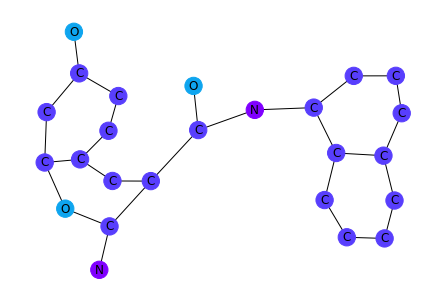

In [14]:
# display the gragh
plt.clf()
visualize(training_set[10])

In [15]:
# print some details about the data
print('length of training data:', len(training_set))
print('Number of labels in train data :', len(training_set[0]))
print('length of testing data:', len(testing_set))
print('Number of labels in test data:', len(testing_set[0]))

length of training data: 40470
Number of labels in train data : 3
length of testing data: 12326
Number of labels in test data: 3


## Preprocessing:

Tokenizing the nodes(atoms)

In [16]:
# import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer

max_vocab = 500 # size of vocabulary
max_len = 100   # maximum length of the tokenized vector

# build vocabulary from training set only for nodes characters
all_nodes = [s[0] for s in training_set]
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
random.seed(0)

# function to prepare single batch set, (samples) represents the batch of data
def prepare_single_batch(samples):
    sample_nodes = [s[0] for s in samples]      # characters(nodes) array
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes) # tokenize the sample nodes
    sample_nodes = pad_sequences(sample_nodes, padding='post') # pad_sequences for each sample node with post padding
    max_nodes_len = np.shape(sample_nodes)[1]                  #shape: (num of samples, number of nodes)(max length of nodes )
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]  #s[1]: links, i*max_nodes_len: to start indexing from current node not from 0 again
    edges = [e for e in edges if len(e) > 0]                          #make sure all elements are non-zero
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]
    
    all_nodes = np.reshape(sample_nodes, -1)      #concatenate nodes of all samples together
    all_edges = np.concatenate(edges)             #concatenate edges of all samples together (because edge is tuple, doesnt hae reshape, output is 2D)

    node_to_graph = np.reshape(node_to_graph, -1)
    # return a dictionary of features(data,edges,node2grah) and label
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])


# function to generate batch with given batch_size 
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)  # length of the dataset
        for ndx in range(0, l, batch_size): # loop to create batches from the  given dataset 
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]  # create batch samples with the given batch_size
 
            yield prepare_single_batch(batch_samples) # return a generator with the given batches
        if not repeat:
            break


In [18]:
# showing one batch:
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():          # k: labels, v: values
        print(k)
        print(v)
        #print(len(v))
        pass
    print('label', train_batch[1])
    break

data
[2 2 2 2 2 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 8 2 2
 2 2 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 3 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 4 2 2 3 3 3 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
edges
[[  0   9]
 [  1  11]
 [  2  15]
 [  3   7]
 [  4   7]
 [  5   6]
 [  5   9]
 [  5  11]
 [  6  10]
 [  7  19]
 [  8   9]
 [  8  10]
 [  8  13]
 [ 10  17]
 [ 11  12]
 [ 12  15]
 [ 12  16]
 [ 13  14]
 [ 14  18]
 [ 14  20]
 [ 15  21]
 [ 16  22]
 [ 18  19]
 [ 19  23]
 [ 20  25]
 [ 21  24]
 [ 22  24]
 [ 23  25]
 [ 34  35]
 [ 34  36]
 [ 34  42]
 [ 35  46]
 [ 36  47]
 [ 37  49]
 [ 37  52]
 [ 38  52]
 [ 39  41]
 [ 39  43]
 [ 39  44]
 [ 40  41]
 [ 40  42]
 [ 42  43]
 [ 44  45]
 [ 45  48]
 [ 46  50]
 [ 47  51]
 [ 48  49]
 [ 52  53]
 [ 68  73]
 [ 68  75]
 [ 69  72]
 [ 70  73]
 [ 71  77]
 [ 71  83]
 [ 71  84]
 [ 72  73]
 [ 72  74]
 [ 72  78]
 [ 74  81]
 [ 74  82]
 [ 75  76]
 [ 75  77]
 [ 76  79]
 [ 76  80]
 [ 78  8

# Function for plotting loss & accuracy

In [19]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("No. of Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [20]:
# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py -->
!pip install --quiet tf2_gnn

# import GNN , GNNInput for deep Graph Neural Network
from tf2_gnn.layers.gnn import GNN, GNNInput

# The reason why we using GNNs 

***Graph Neural Networks (GNNs)** are a class of deep learning methods designed to perform inference on data described by graphs. GNNs are neural networks that can be directly applied to graphs, and provide an easy way to do node-level, edge-level, and graph-level prediction tasks. [1]

Here our data contain chemical compound  which is represented as a graph, with atoms representing nodes and bonds as edges and we need to make a prediction for anticancer activity.

Therefore, the most appropriate method is to use **GNNs** 

# Trial_1

**Thoughts and observations for trial 1, plan for trial 2**

**Thoughts**

I will build a GNN model to make a prediction based on our data (SDF file) with hyperparamters 

* params["hidden_dim"] = 32

I will build the model by adding Embedding layer to enables us to convert each word into a fixed length vector of defined size and adding a GNN input layer to encode data about the graph's structure. then uses this data to update the node and edge representations that were created at the start , adding dense(1,activation='sigmoid') as here we only output 1 probability and it is a binary classification

**Expectation**

The model's  performance will be good and the model will learn well as the GNN models are رery well suited to the type of data used (SDF) to develop and evaluate the model in order to achieve the best prediction.

**Observation**

The model's performance will be good and may not happen overfitting or underfitting.

**Plan for Trial_2**

I will apply any aggregation mechanisms (aka message_passing mechanisms) used in the graph convolution layer.

In [21]:
# import libraries needed to build model 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.math import segment_mean

 #Input layer for nodes
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)     # Input layer for edge data    # edge is 2D 
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # Input layer for node2graph
embeded = Embedding(tokenizer.num_words, 20)(data)            # define embedding layer

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32   # hidden dimension of gnn layer 
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)  # gnn output layer 

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(data=gnn_out,segment_ids=node2graph)  #calculating segmented mean based on segment_ids
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)        #binary classification: Dense(1), here we only output 1 probability
print('pred:', pred)



model_1 = Model(
    #inputs are data,edges and node2graph
    inputs={   
        'data': data,
        'edges': edge,
        'node2grah': node2graph,},
    #output: prediction value from dense layer
    outputs=pred)
# print summary of model 
model_1.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

In [22]:
# compile model 
model_1.compile(loss='BinaryCrossentropy',metrics=['AUC'])

In [23]:
import math

batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size)               # number of batches for training data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)  # number of batches for validation data

# fit model 
model1=model_1.fit(gen_batch(training_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(validation_set, batch_size=32, repeat=True),
    validation_steps=num_batchs_validation)

Epoch 1/20
1265/1265 [==============================] - 26s 18ms/step - loss: 0.6276 - auc: 0.7038 - val_loss: 0.6028 - val_auc: 0.7412
Epoch 2/20
1265/1265 [==============================] - 23s 18ms/step - loss: 0.5974 - auc: 0.7427 - val_loss: 0.5995 - val_auc: 0.7528
Epoch 3/20
1265/1265 [==============================] - 23s 18ms/step - loss: 0.5830 - auc: 0.7587 - val_loss: 0.5808 - val_auc: 0.7661
Epoch 4/20
1265/1265 [==============================] - 23s 18ms/step - loss: 0.5727 - auc: 0.7720 - val_loss: 0.5658 - val_auc: 0.7788
Epoch 5/20
1265/1265 [==============================] - 23s 18ms/step - loss: 0.5627 - auc: 0.7812 - val_loss: 0.5598 - val_auc: 0.7901
Epoch 6/20
1265/1265 [==============================] - 24s 19ms/step - loss: 0.5517 - auc: 0.7929 - val_loss: 0.5623 - val_auc: 0.8016
Epoch 7/20
1265/1265 [==============================] - 24s 19ms/step - loss: 0.5400 - auc: 0.8030 - val_loss: 0.5394 - val_auc: 0.8086
Epoch 8/20
1265/1265 [==========================

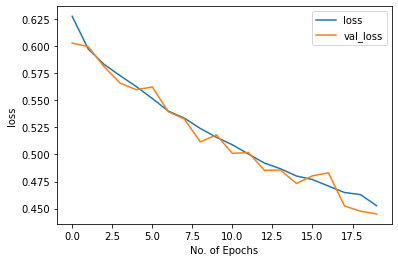

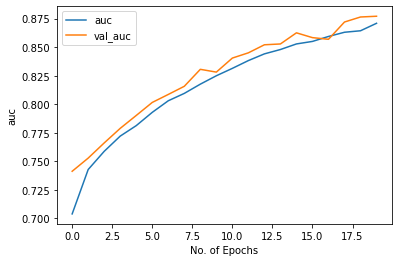

In [24]:
plot_graphs(model1, "loss")
plot_graphs(model1, "auc")

**Observation**

After running the model I observed that the model's performance was good as I expected the the model learned well as there is no overfitting or underfitting according to the plot of (loss & accuracy) 

In [25]:
# get the prediction values from predict model 
y_pred = model_1.predict(gen_batch(testing_set, batch_size=16, shuffle=False))
y_pred = np.reshape(y_pred, -1)
y_pred

array([0.9734099 , 0.507299  , 0.00925031, ..., 0.0065051 , 0.90272677,
       0.11652341], dtype=float32)

In [26]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_1.csv') # Score: 0.81824

# Trial_2

**Thoughts and observations for trial 2, plan for trial 3**

**Thoughts**

I will build a GNN model to make a prediction based on our data (SDF file) with hyperparamters

* params["hidden_dim"] = 32

* params["message_calculation_class"] = 'GGNN'

I will build the model by adding Embedding layer to enables us to convert each word into a fixed length vector of defined size and adding a GNN input layer to encode data about the graph's structure.then uses this data to update the node and edge representations that were created at the start , adding dense(1,activation='sigmoid') as here we only output 1 probability and it is a binary classification

Here I used GGNN as an aggregation mechanisms  in the graph convolution layer because GGNN perform well on problems with long-term dependencies.The long-term dependencies are encoded by node and edge gates.  Therefore, Gated Graph Neural Networks improve Recurrent Graph Neural Networks by adding gating mechanisms. These gates are responsible for remembering and forgetting information in different states.[1]

**Expectation**

The model's performance will be very good and the model will learn well as the GNN with GGNN as an aggregation mechanisms models are very well suited to the type of data used (SDF) to develop and evaluate the model in order to achieve the best prediction.

**Observation**

The model's performance will be very good and may not happen overfitting or underfitting.

**Plan for Trial_3**

I will apply other aggregation mechanisms **RGCN** that used in the graph convolution layer To find out  its effect on the model performance.

In [27]:
# import libraries needed to build model 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.math import segment_mean

 #Input layer for nodes
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)     # Input layer for edge data    # edge is 2D 
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # Input layer for node2graph
embeded = Embedding(tokenizer.num_words, 20)(data)            # define embedding layer

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params['hidden_dim'] = 32   # hidden dimension of gnn layer 
params["message_calculation_class"] = 'GGNN' # configures the message passing style using GGNN layer 
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)  # gnn output layer 

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(data=gnn_out,segment_ids=node2graph)  #calculating segmented mean based on segment_ids
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)        #binary classification: Dense(1), but here we only output 1 probability
print('pred:', pred)



model_2 = Model(
    #inputs are data,edges and node2graph
    inputs={   
        'data': data,
        'edges': edge,
        'node2grah': node2graph,},
    #output: prediction value from dense layer
    outputs=pred)
# print summary of model 
model_2.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_1/StatefulPartitionedCall:0', description="created by layer 'gnn_1'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_1/SegmentMean:0', description="created by layer 'tf.math.segment_mean_1'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_1/Sigmoid:0', description="created by layer 'dense_1'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []        

In [28]:
# compile model 
model_2.compile(loss='BinaryCrossentropy',metrics=['AUC'])

In [29]:
import math

batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size)               # number of batches for training data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)  # number of batches for validation data

# fit model 
model2=model_2.fit(gen_batch(training_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(validation_set, batch_size=32, repeat=True),
    validation_steps=num_batchs_validation)

Epoch 1/30
1265/1265 [==============================] - 43s 31ms/step - loss: 0.6262 - auc: 0.6989 - val_loss: 0.6209 - val_auc: 0.7247
Epoch 2/30
1265/1265 [==============================] - 39s 31ms/step - loss: 0.5907 - auc: 0.7450 - val_loss: 0.5939 - val_auc: 0.7670
Epoch 3/30
1265/1265 [==============================] - 38s 30ms/step - loss: 0.5674 - auc: 0.7706 - val_loss: 0.5574 - val_auc: 0.7864
Epoch 4/30
1265/1265 [==============================] - 39s 30ms/step - loss: 0.5473 - auc: 0.7909 - val_loss: 0.5402 - val_auc: 0.8102
Epoch 5/30
1265/1265 [==============================] - 39s 31ms/step - loss: 0.5221 - auc: 0.8160 - val_loss: 0.5067 - val_auc: 0.8391
Epoch 6/30
1265/1265 [==============================] - 39s 31ms/step - loss: 0.4964 - auc: 0.8381 - val_loss: 0.4756 - val_auc: 0.8542
Epoch 7/30
1265/1265 [==============================] - 39s 31ms/step - loss: 0.4738 - auc: 0.8548 - val_loss: 0.4600 - val_auc: 0.8705
Epoch 8/30
1265/1265 [==========================

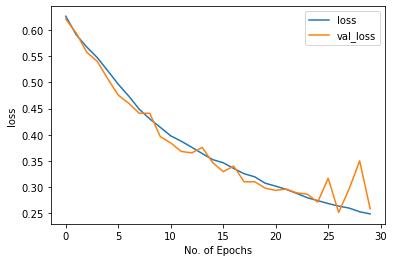

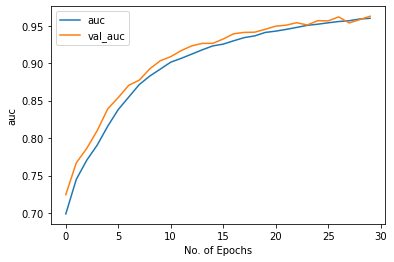

In [30]:
plot_graphs(model2, "loss")
plot_graphs(model2, "auc")

**Observation**

After running the model I observed that the model's performance was very good as I expected the the model learned well as there is no overfitting or underfitting according to the plot of (loss & accuracy) 
which mean using GGNN aggregation mechanisms has a good effect on the model's performance.

In [32]:
# get the prediction values from predict model 
y_pred = model_2.predict(gen_batch(testing_set, batch_size=16, shuffle=False))
y_pred = np.reshape(y_pred, -1)
y_pred

array([9.5013392e-01, 5.1426125e-01, 8.1446767e-04, ..., 6.1817467e-03,
       3.5528807e-05, 9.9883080e-01], dtype=float32)

In [33]:
import pandas as pd 

submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_2.csv') # Score: 0.87567

# Trial_3

**Thoughts and observations for trial 3, plan for trial 4**

**Thoughts**

I will build a GNN model to make a prediction based on our data (SDF file) with hyperparamters

* params["hidden_dim"] = 32

* params["message_calculation_class"] = 'RGCN'

I will build the model by adding Embedding layer to enables us to convert each word into a fixed length vector of defined size and adding a GNN input layer to encode data about the graph's structure.then uses this data to update the node and edge representations that were created at the start , adding dense(1,activation='sigmoid') as here we only output 1 probability and it is a binary classification

Here I used RGCN as an aggregation mechanisms in the graph convolution layer 

R-GCN has been proposed as a multi-relational version of the GCN architecture and has shown state-of-the-art performance on standard knowledge graph completion tasks including entity classification and link prediction.[2]

**Expectation**

The model's performance will be very good and the model will learn well as the GNN with RGCN as an aggregation mechanisms models are very well suited to the type of data as R-GCN is defined over the multimodal graphs and it will appropiate to develop and evaluate the model in order to achieve the best prediction.

**Observation**

The model will learn and perform well and get high accuracy and may not happen overfitting or underfitting.

**Plan for Trial_4**

I will apply other aggregation mechanisms **RGAT** that used in the graph convolution layer To find out its effect on the model performance.

In [70]:
# import libraries needed to build model 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.math import segment_mean

 #Input layer for nodes
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)     # Input layer for edge data    # edge is 2D 
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # Input layer for node2graph
embeded = Embedding(tokenizer.num_words, 20)(data)            # define embedding layer with each token embedded as size vector

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params['hidden_dim'] = 32   # hidden dimension of gnn layer 
params["message_calculation_class"] = 'RGCN' # configures the message passing style using RGCN layer 
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)  # gnn output layer 

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(data=gnn_out,segment_ids=node2graph)  #calculating segmented mean based on segment_ids
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)        #binary classification: Dense(1), but here we only output 1 probability
print('pred:', pred)



model_3 = Model(
    #inputs are data,edges and node2graph
    inputs={   
        'data': data,
        'edges': edge,
        'node2grah': node2graph,},
    #output: prediction value from dense layer
    outputs=pred)
# print summary of model 
model_3.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_8/StatefulPartitionedCall:0', description="created by layer 'gnn_8'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_8/SegmentMean:0', description="created by layer 'tf.math.segment_mean_8'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_8/Sigmoid:0', description="created by layer 'dense_8'")
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_25 (InputLayer)          [(None,)]            0           []        

In [71]:
# compile model 
model_3.compile(loss='BinaryCrossentropy',metrics=['AUC'])

In [72]:
import math

batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size)               # number of batches for training data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)  # number of batches for validation data

# fit model 
model3=model_3.fit(gen_batch(training_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(validation_set, batch_size=32, repeat=True),
    validation_steps=num_batchs_validation)

Epoch 1/30
1265/1265 [==============================] - 32s 23ms/step - loss: 0.6311 - auc: 0.6961 - val_loss: 0.6300 - val_auc: 0.7216
Epoch 2/30
1265/1265 [==============================] - 30s 24ms/step - loss: 0.6056 - auc: 0.7285 - val_loss: 0.6026 - val_auc: 0.7432
Epoch 3/30
1265/1265 [==============================] - 28s 22ms/step - loss: 0.5916 - auc: 0.7460 - val_loss: 0.5837 - val_auc: 0.7625
Epoch 4/30
1265/1265 [==============================] - 28s 22ms/step - loss: 0.5753 - auc: 0.7664 - val_loss: 0.5596 - val_auc: 0.7891
Epoch 5/30
1265/1265 [==============================] - 28s 22ms/step - loss: 0.5590 - auc: 0.7834 - val_loss: 0.5503 - val_auc: 0.8020
Epoch 6/30
1265/1265 [==============================] - 29s 23ms/step - loss: 0.5547 - auc: 0.7889 - val_loss: 0.5436 - val_auc: 0.8060
Epoch 7/30
1265/1265 [==============================] - 28s 23ms/step - loss: 0.5382 - auc: 0.8046 - val_loss: 0.5346 - val_auc: 0.8185
Epoch 8/30
1265/1265 [==========================

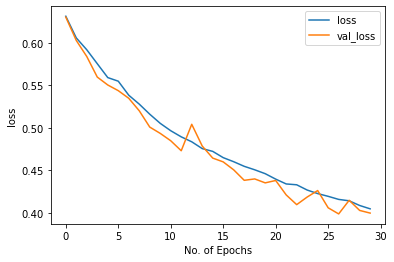

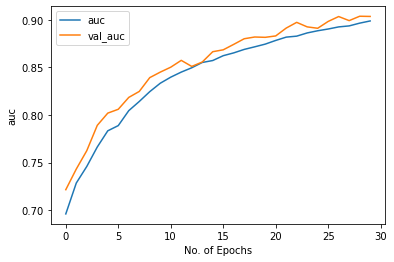

In [73]:
plot_graphs(model3, "loss")
plot_graphs(model3, "auc")

**Observation**

After running the model I observed that the model's performance was good as I expected the the model learned well as there is no overfitting or underfitting according to the plot of (loss & accuracy) which mean using RGCN aggregation mechanisms has a good effect on the model's performance because R-GCN is defined over the multimodal graphs and our data is (SDF) and we use graghical dataset consist of nodes and links.

In [74]:
# get the prediction values from predict model 
y_pred = model_3.predict(gen_batch(testing_set, batch_size=16, shuffle=False))
y_pred = np.reshape(y_pred, -1)
y_pred

array([0.9334045 , 0.03878155, 0.03476074, ..., 0.05058426, 0.5389121 ,
       0.15806216], dtype=float32)

In [42]:
import pandas as pd 

submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_3.csv') # Score: 0.81466

# Trial_4

**Thoughts and observations for trial 4, plan for trial 5**

**Thoughts**

I will build a GNN model to make a prediction based on our data (SDF file) with hyperparamters

* params["hidden_dim"] = 12

* params["message_calculation_class"] = 'RGAT'

* params["num_heads"] = 3

I will build the model by adding Embedding layer to enables us to convert each word into a fixed length vector of defined size and adding a GNN input layer to encode data about the graph's structure.then uses this data to update the node and edge representations that were created at the start , adding dense(1,activation='sigmoid') as here we only output 1 probability and it is a binary classification

Here I used RGAt as an aggregation mechanisms in the graph convolution layer

Graph Attention Network (GAT) focuses on modelling simple undirected and single relational graph data only. This limits its ability to deal with more general and complex multi-relational graphs that contain entities with directed links of different labels (e.g., knowledge graphs).[3]

**Expectation**

The model may perform and learn well with  the GNN with RGAT as an aggregation mechanisms models as RGAT focuses on modelling simple undirected and single relational graph data.

**Observation**

The model may learn and perform well and may get high accuracy and may not happen overfitting or underfitting.

**Plan for Trial_5**

I will apply other aggregation mechanisms **RGIN** that used in the graph convolution layer To find out its effect on the model performance.

In [43]:
# import libraries needed to build model 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.math import segment_mean
from  tf2_gnn.layers.message_passing import RGAT,  MessagePassing, MessagePassingInput

 #Input layer for nodes
data = keras.Input(batch_shape=(None,))  

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)        # Input layer for edge data    # edge is 2D 
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)    # Input layer for node2graph

embeded = Embedding(tokenizer.num_words, 20)(data)              # define embedding layer


# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1  

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 12                     # hidden dimension of gnn layer (size of the output of all message passing layers)
params["message_calculation_class"] = 'RGAT'  # configures the message passing style using RGAT layer 
params["num_heads"] = 3
gnn_layer = GNN(params)  


gnn_out = gnn_layer(gnn_input)   # gnn output layer 
print('gnn_out', gnn_out)           

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(data=gnn_out,segment_ids=node2graph)  #calculating segmented mean based on segment_ids
print('mean:', avg)


pred = Dense(1, activation='sigmoid')(avg)   #binary classification: Dense(1), but here we only output 1 probability
print('pred:', pred)


model_4 = Model(
    #inputs are data,edges and node2graph
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,},
    #output: prediction value from dense layer
    outputs=pred
)

# print summary of the model
model_4.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 12), dtype=tf.float32, name=None), name='gnn_3/StatefulPartitionedCall:0', description="created by layer 'gnn_3'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 12), dtype=tf.float32, name=None), name='tf.math.segment_mean_3/SegmentMean:0', description="created by layer 'tf.math.segment_mean_3'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_3/Sigmoid:0', description="created by layer 'dense_3'")
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None,)]            0           []        

In [44]:
# compile model 
model_4.compile(loss='BinaryCrossentropy',metrics=['AUC'])

In [45]:
import math

batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size)               # number of batches for training data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)  # number of batches for validation data

# fit model 
model4=model_4.fit(gen_batch(training_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(validation_set, batch_size=32, repeat=True),
    validation_steps=num_batchs_validation)

Epoch 1/30
1265/1265 [==============================] - 24s 16ms/step - loss: 0.6397 - auc: 0.6774 - val_loss: 0.6316 - val_auc: 0.7006
Epoch 2/30
1265/1265 [==============================] - 21s 16ms/step - loss: 0.6151 - auc: 0.7164 - val_loss: 0.6176 - val_auc: 0.7207
Epoch 3/30
1265/1265 [==============================] - 19s 15ms/step - loss: 0.6025 - auc: 0.7342 - val_loss: 0.5975 - val_auc: 0.7486
Epoch 4/30
1265/1265 [==============================] - 19s 15ms/step - loss: 0.5945 - auc: 0.7459 - val_loss: 0.5972 - val_auc: 0.7518
Epoch 5/30
1265/1265 [==============================] - 19s 15ms/step - loss: 0.5890 - auc: 0.7521 - val_loss: 0.5924 - val_auc: 0.7572
Epoch 6/30
1265/1265 [==============================] - 19s 15ms/step - loss: 0.5846 - auc: 0.7602 - val_loss: 0.5805 - val_auc: 0.7694
Epoch 7/30
1265/1265 [==============================] - 18s 15ms/step - loss: 0.5788 - auc: 0.7671 - val_loss: 0.5840 - val_auc: 0.7690
Epoch 8/30
1265/1265 [==========================

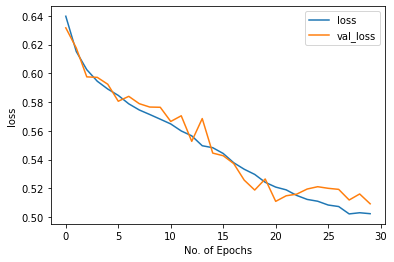

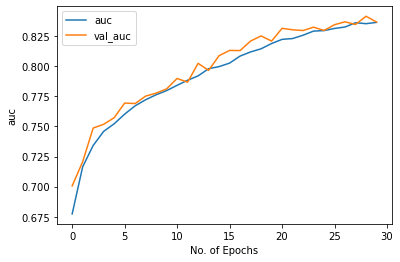

In [46]:
plot_graphs(model4, "loss")
plot_graphs(model4, "auc")

**Observation**

After running the model I observed that the model's performance was good and learned well as there is no overfitting or underfitting according to the plot of (loss & accuracy) which mean using RGAT aggregation mechanisms has a good effect on the model's performance as RGAT focusses on the modelling of undirected and single relational graph data.

In [47]:
# get the prediction values from predict model 
y_pred = model_4.predict(gen_batch(testing_set, batch_size=16, shuffle=False))
y_pred = np.reshape(y_pred, -1)
y_pred

array([0.85976195, 0.58689296, 0.01958176, ..., 0.07441568, 0.54966897,
       0.25389344], dtype=float32)

In [48]:
import pandas as pd 

submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_4.csv') # Score: 0.83770

# Trial_5

**Thoughts and observations for trial 5, plan for trial 6**

**Thoughts**

I will build a GNN model to make a prediction based on our data (SDF file) with hyperparamters

* params["hidden_dim"] = 32

* params["message_calculation_class"] = 'RGIN'

* params['num_aggr_MLP_hidden_layers'] = 12 which mean (Number of hidden layers of the MLPs used on the aggregation of messages from neighbouring nodes).

I will build the model by adding Embedding layer to enables us to convert each word into a fixed length vector of defined size and adding a GNN input layer to encode data about the graph's structure.then uses this data to update the node and edge representations that were created at the start , adding dense(1,activation='sigmoid') as here we only output 1 probability and it is a binary classification

Here I used RGAt as an aggregation mechanisms in the graph convolution layer

GIN is a dual representation of convolutional neural network (CNN) in the graph space where the shift operation is defined using the adjacency matrix.[4]

**Expectation**

The model may perform and learn very well with the GNN with RGIN an aggregation mechanisms models as GIN is a dual representation of convolutional neural network (CNN) in the graph space.

**Observation**

The model may learn and perform well and may get high accuracy and may not happen overfitting or underfitting.

**Plan for Trial_6**

I will apply other aggregation mechanisms **GGNN** that used in the graph convolution layer and change haperparameters To find out its effect on the model's performance.

In [49]:
# import libraries needed to build model 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.math import segment_mean

 #Input layer for nodes
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)     # Input layer for edge data    # edge is 2D 
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # Input layer for node2graph
embeded = Embedding(tokenizer.num_words, 20)(data)            # define embedding layer

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params['hidden_dim'] = 32    # hidden dimension of gnn layer (embedding layer over data with each token embedded as size vector)
params['num_aggr_MLP_hidden_layers'] = 12    
params["message_calculation_class"] = 'RGIN' # configures the message passing style using RGIN layer 
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)  # gnn output layer 

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(data=gnn_out,segment_ids=node2graph)  #calculating segmented mean based on segment_ids
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)        #binary classification: Dense(2), but here we only output 1 probability
print('pred:', pred)



model_5 = Model(
    #inputs are data,edges and node2graph
    inputs={   
        'data': data,
        'edges': edge,
        'node2grah': node2graph,},
    #output: prediction value from dense layer
    outputs=pred)
# print summary of model 
model_5.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_4/StatefulPartitionedCall:0', description="created by layer 'gnn_4'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_4/SegmentMean:0', description="created by layer 'tf.math.segment_mean_4'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_4/Sigmoid:0', description="created by layer 'dense_4'")
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None,)]            0           []        

In [50]:
# compile model 
model_5.compile(loss='BinaryCrossentropy',metrics=['AUC'])

In [51]:
import math

batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size)               # number of batches for training data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)  # number of batches for validation data

# fit model 
model5=model_5.fit(gen_batch(training_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(validation_set, batch_size=32, repeat=True),
    validation_steps=num_batchs_validation)

Epoch 1/30
1265/1265 [==============================] - 58s 41ms/step - loss: 0.6408 - auc: 0.6860 - val_loss: 0.6286 - val_auc: 0.7355
Epoch 2/30
1265/1265 [==============================] - 49s 38ms/step - loss: 0.6165 - auc: 0.7237 - val_loss: 0.6247 - val_auc: 0.7354
Epoch 3/30
1265/1265 [==============================] - 52s 41ms/step - loss: 0.6101 - auc: 0.7311 - val_loss: 0.5978 - val_auc: 0.7513
Epoch 4/30
1265/1265 [==============================] - 51s 40ms/step - loss: 0.5999 - auc: 0.7448 - val_loss: 0.5931 - val_auc: 0.7621
Epoch 5/30
1265/1265 [==============================] - 48s 38ms/step - loss: 0.5952 - auc: 0.7499 - val_loss: 0.5753 - val_auc: 0.7727
Epoch 6/30
1265/1265 [==============================] - 51s 40ms/step - loss: 0.5864 - auc: 0.7612 - val_loss: 0.6009 - val_auc: 0.7627
Epoch 7/30
1265/1265 [==============================] - 51s 40ms/step - loss: 0.5853 - auc: 0.7633 - val_loss: 0.5727 - val_auc: 0.7944
Epoch 8/30
1265/1265 [==========================

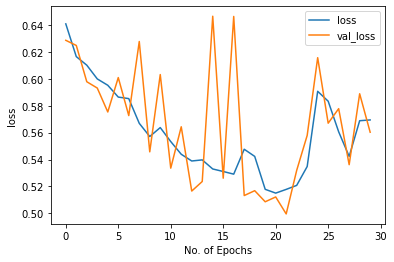

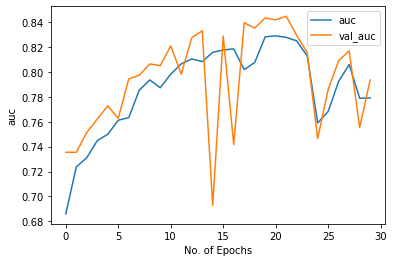

In [52]:
plot_graphs(model5, "loss")
plot_graphs(model5, "auc")

**Observation**

After running the model I observed that the model's performance was not very good and didn't learn well as there is a little   underfitting according to the plot of (loss & accuracy) which mean using RGIN aggregation mechanisms has not  good effect on the model's performance.

In [53]:
# get the prediction values from predict model 
y_pred = model_5.predict(gen_batch(testing_set, batch_size=16, shuffle=False))
y_pred = np.reshape(y_pred, -1)
y_pred

array([0.9012191 , 0.3040504 , 0.42816985, ..., 0.10967001, 0.32801116,
       0.59050024], dtype=float32)

In [54]:
import pandas as pd 

submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_5.csv') # Score: 0.80590

# Trial_6

**Thoughts and observations for trial 6, plan for trial 7**

**Thoughts**

I will build a GNN model to make a prediction based on our data (SDF file) with hyperparamters

* params["hidden_dim"] = 64

* params['dense_every_num_layers']=32

* params["message_calculation_class"] = 'GGNN'

I will build the model by adding Embedding layer to enables us to convert each word into a fixed length vector of defined size and adding a GNN input layer to encode data about the graph's structure.then uses this data to update the node and edge representations that were created at the start , adding dense(1,activation='sigmoid') as here we only output 1 probability and it is a binary classification

Here I used GGNN as an aggregation mechanisms  in the graph convolution layer because GGNN perform well on problems with long-term dependencies.The long-term dependencies are encoded by node and edge gates.  Therefore, Gated Graph Neural Networks improve Recurrent Graph Neural Networks by adding gating mechanisms. These gates are responsible for remembering and forgetting information in different states.[1]

**Expectation**

The model's performance will be very good and the model will learn well as I change ["hidden_dim"] = 64 insted of 32 to let size of the output of all message passing layers to be bigger and using ['dense_every_num_layers']=32 and using  the GNN with GGNN as an aggregation mechanisms models are very well suited to the type of data used (SDF) to develop and evaluate the model in order to achieve the best prediction.

**Observation**

The model's performance will be very good and may not happen overfitting or underfitting.

**Plan for Trial_7**

I will apply other aggregation mechanisms **GGNN** that used in the graph convolution layer and change hyperparameters and add ['dense_intermediate_layer_activation'] hyperparameter  To find out  its effect on the model performance.

In [55]:
# import libraries needed to build model 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.math import segment_mean

 #Input layer for nodes
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)     # Input layer for edge data    # edge is 2D 
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # Input layer for node2graph
embeded = Embedding(tokenizer.num_words, 20)(data)            # define embedding layer

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params['hidden_dim'] = 64                # hidden dimension of gnn layer 
params['dense_every_num_layers']=32      # configures how often a per-node representation
params["message_calculation_class"] = 'GGNN' # configures the message passing style using RGIN layer 
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)  # gnn output layer 

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(data=gnn_out,segment_ids=node2graph)  #calculating segmented mean based on segment_ids
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)        #binary classification: Dense(1), but here we only output 1 probability
print('pred:', pred)



model_6 = Model(
    #inputs are data,edges and node2graph
    inputs={   
        'data': data,
        'edges': edge,
        'node2grah': node2graph,},
    #output: prediction value from dense layer
    outputs=pred)
# print summary of model 
model_6.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_5/StatefulPartitionedCall:0', description="created by layer 'gnn_5'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_5/SegmentMean:0', description="created by layer 'tf.math.segment_mean_5'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_5/Sigmoid:0', description="created by layer 'dense_5'")
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None,)]            0           []        

In [56]:
# compile model 
model_6.compile(loss='BinaryCrossentropy',metrics=['AUC'])

In [57]:
import math

batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size)               # number of batches for training data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)  # number of batches for validation data

# fit model 
model6=model_6.fit(gen_batch(training_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(validation_set, batch_size=32, repeat=True),
    validation_steps=num_batchs_validation)

Epoch 1/30
1265/1265 [==============================] - 97s 74ms/step - loss: 0.6250 - auc: 0.7026 - val_loss: 0.6054 - val_auc: 0.7525
Epoch 2/30
1265/1265 [==============================] - 94s 74ms/step - loss: 0.5623 - auc: 0.7793 - val_loss: 0.5308 - val_auc: 0.8167
Epoch 3/30
1265/1265 [==============================] - 95s 75ms/step - loss: 0.5025 - auc: 0.8343 - val_loss: 0.4768 - val_auc: 0.8550
Epoch 4/30
1265/1265 [==============================] - 94s 75ms/step - loss: 0.4676 - auc: 0.8596 - val_loss: 0.4487 - val_auc: 0.8752
Epoch 5/30
1265/1265 [==============================] - 95s 75ms/step - loss: 0.4360 - auc: 0.8799 - val_loss: 0.4316 - val_auc: 0.8834
Epoch 6/30
1265/1265 [==============================] - 96s 76ms/step - loss: 0.4031 - auc: 0.8987 - val_loss: 0.3843 - val_auc: 0.9145
Epoch 7/30
1265/1265 [==============================] - 95s 75ms/step - loss: 0.3732 - auc: 0.9135 - val_loss: 0.3737 - val_auc: 0.9156
Epoch 8/30
1265/1265 [==========================

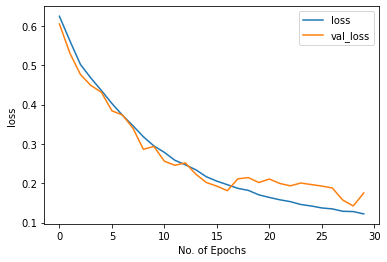

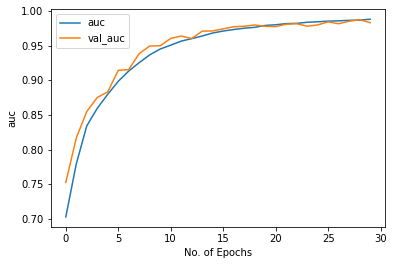

In [58]:
plot_graphs(model6, "loss")
plot_graphs(model6, "auc")

**Observation**

After running the model I observed that the model perform  very good and gave a very high accuracy and the model learnt very well as there is no underfitting or overfitting  according to the plot of (loss & accuracy) which mean using GGNN aggregation mechanisms with ['hidden_dim'] = 64 and ['dense_every_num_layers']=32  has a very good effect on the model's performance.

In [59]:
# get the prediction values from predict model 
y_pred = model_6.predict(gen_batch(testing_set, batch_size=16, shuffle=False))
y_pred = np.reshape(y_pred, -1)
y_pred

array([4.2021871e-03, 7.5241923e-04, 7.4345582e-05, ..., 1.9151416e-06,
       3.1632112e-07, 9.4939542e-01], dtype=float32)

In [60]:
import pandas as pd 

submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_6.csv') # Score: 0.86056

# Trial_7

**Thoughts and observations for trial 7, plan for trial 8**

**Thoughts**

I will build a GNN model to make a prediction based on our data (SDF file) with hyperparamters

* params["hidden_dim"] = 64

* params['dense_every_num_layers']=8

* params['dense_intermediate_layer_activation']='tanh'

* params["message_calculation_class"] = 'GGNN'

I will build the model by adding Embedding layer to enables us to convert each word into a fixed length vector of defined size and adding a GNN input layer to encode data about the graph's structure.then uses this data to update the node and edge representations that were created at the start , adding dense(1,activation='sigmoid') as here we only output 1 probability and it is a binary classification

Here I used GGNN as an aggregation mechanisms in the graph convolution layer because GGNN perform well on problems with long-term dependencies.The long-term dependencies are encoded by node and edge gates. Therefore, Gated Graph Neural Networks improve Recurrent Graph Neural Networks by adding gating mechanisms. These gates are responsible for remembering and forgetting information in different states.[1]

**Expectation**

The model's performance will be very good and the model will learn well as I change ["hidden_dim"] = 64 insted of 32 to let size of the output of all message passing layers to be bigger and using ['dense_every_num_layers']=8 and params['dense_intermediate_layer_activation']='tanh'and using the GNN with GGNN as an aggregation mechanisms models are very well suited to the type of data used (SDF) to develop and evaluate the model in order to achieve the best prediction.

my expectation that the model performance may affect as I change the hyperparamets and add avtivation function

**Observation**

The model's performance will be very good and may not happen overfitting or underfitting.

**Plan for Trial_8**

I will apply other aggregation mechanisms GGNN that used in the graph convolution layer and change hyperparameters to be ['hidden_dim'] = 64  and remove ['dense_every_num_layers'] To find out if there is  effect on the model performance or not.

In [64]:
# import libraries needed to build model 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.math import segment_mean

 #Input layer for nodes
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)     # Input layer for edge data    # edge is 2D 
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # Input layer for node2graph
embeded = Embedding(tokenizer.num_words, 20)(data)            # define embedding layer

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params['hidden_dim'] = 64          # hidden dimension of gnn layer(sets the size of the output of all message passing layers)
params['dense_every_num_layers'] = 8                 #  configures how often a per-node 
params['dense_intermediate_layer_activation']='tanh' # configures the activation 
params["message_calculation_class"] = 'GGNN' # configures the message passing style using RGCN layer 
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)  # gnn output layer 

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(data=gnn_out,segment_ids=node2graph)  #calculating segmented mean based on segment_ids
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)        #binary classification: Dense(1), but here we only output 1 probability
print('pred:', pred)



model_7 = Model(
    #inputs are data,edges and node2graph
    inputs={   
        'data': data,
        'edges': edge,
        'node2grah': node2graph,},
    #output: prediction value from dense layer
    outputs=pred)
# print summary of model 
model_7.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_7/StatefulPartitionedCall:0', description="created by layer 'gnn_7'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_7/SegmentMean:0', description="created by layer 'tf.math.segment_mean_7'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_7/Sigmoid:0', description="created by layer 'dense_7'")
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None,)]            0           []        

In [65]:
# compile model 
model_7.compile(loss='BinaryCrossentropy',metrics=['AUC'])

In [66]:
import math

batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size)               # number of batches for training data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)  # number of batches for validation data

# fit model 
model7=model_7.fit(gen_batch(training_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(validation_set, batch_size=32, repeat=True),
    validation_steps=num_batchs_validation)

Epoch 1/30
1265/1265 [==============================] - 110s 84ms/step - loss: 0.6147 - auc: 0.7152 - val_loss: 0.5826 - val_auc: 0.7657
Epoch 2/30
1265/1265 [==============================] - 103s 81ms/step - loss: 0.5563 - auc: 0.7847 - val_loss: 0.5110 - val_auc: 0.8297
Epoch 3/30
1265/1265 [==============================] - 103s 81ms/step - loss: 0.4929 - auc: 0.8426 - val_loss: 0.4664 - val_auc: 0.8639
Epoch 4/30
1265/1265 [==============================] - 107s 85ms/step - loss: 0.4542 - auc: 0.8688 - val_loss: 0.4311 - val_auc: 0.8835
Epoch 5/30
1265/1265 [==============================] - 105s 83ms/step - loss: 0.4192 - auc: 0.8897 - val_loss: 0.3789 - val_auc: 0.9116
Epoch 6/30
1265/1265 [==============================] - 105s 83ms/step - loss: 0.3900 - auc: 0.9051 - val_loss: 0.3481 - val_auc: 0.9249
Epoch 7/30
1265/1265 [==============================] - 104s 82ms/step - loss: 0.3647 - auc: 0.9169 - val_loss: 0.3467 - val_auc: 0.9257
Epoch 8/30
1265/1265 [===================

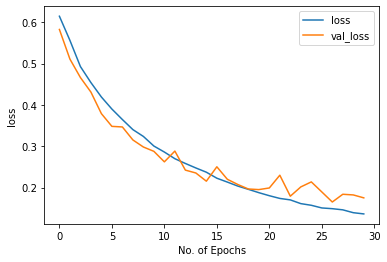

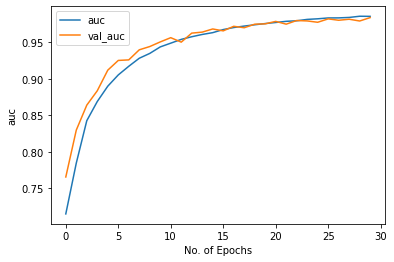

In [67]:
plot_graphs(model7, "loss")
plot_graphs(model7, "auc")

**Observation**

After running the model I observed that the model's performanc almost the same as in Trail_6. The model perform very good and gave a very high accuracy and the model learnt very well as there is no underfitting or overfitting according to the plot of (loss & accuracy) which mean using GGNN aggregation mechanisms with ['hidden_dim'] = 64 and ['dense_every_num_layers']=8 and ['dense_intermediate_layer_activation'] ='tanh'  has a very good effect on the model's performance.

In [68]:
# get the prediction values from predict model 
y_pred = model_7.predict(gen_batch(testing_set, batch_size=16, shuffle=False))
y_pred = np.reshape(y_pred, -1)
y_pred

array([4.6380481e-01, 2.0950422e-07, 4.5973522e-07, ..., 5.2161813e-03,
       1.5485287e-04, 9.9925542e-01], dtype=float32)

In [69]:
import pandas as pd 

submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_7.csv')

# Trial_8

**Thoughts and observations for trial 8, plan for trial 9**

**Thoughts**

I will build a GNN model to make a prediction based on our data (SDF file) with hyperparamters

* params["hidden_dim"] = 64

* params["message_calculation_class"] = 'GGNN'

I will build the model by adding Embedding layer to enables us to convert each word into a fixed length vector of defined size and adding a GNN input layer to encode data about the graph's structure.then uses this data to update the node and edge representations that were created at the start , adding dense(1,activation='sigmoid') as here we only output 1 probability and it is a binary classification

Here I used GGNN as an aggregation mechanisms in the graph convolution layer because GGNN perform well on problems with long-term dependencies.The long-term dependencies are encoded by node and edge gates. Therefore, Gated Graph Neural Networks improve Recurrent Graph Neural Networks by adding gating mechanisms. These gates are responsible for remembering and forgetting information in different states.[1]

**Expectation**

The model's performance will be very good and the model will learn well as I change ["hidden_dim"] = 64 and using the GNN with GGNN as an aggregation mechanisms models are very well suited to the type of data used (SDF) to develop and evaluate the model in order to achieve the best prediction.

my expectation that the model performance may affect as I change the hyperparamets and add avtivation function

**Observation**

The model's performance will be good but less than the previous trial as I remove ["dense_every_num_layers"] and may not happen overfitting or underfitting.

**Plan for Trial_9**

I will apply other aggregation mechanisms GGNN that used in the graph convolution layer and change hyperparameters to be ['hidden_dim'] = 64 and remove ['dense_every_num_layers'] To find out if there is effect on the model performance or not.

In [81]:
# import libraries needed to build model 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.math import segment_mean

 #Input layer for nodes
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)     # Input layer for edge data    # edge is 2D 
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # Input layer for node2graph
embeded = Embedding(tokenizer.num_words, 20)(data)            # define embedding layer

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params['hidden_dim'] = 64   # hidden dimension of gnn layer 
params["message_calculation_class"] = 'GGNN' # configures the message passing style using RGCN layer 
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)  # gnn output layer 

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(data=gnn_out,segment_ids=node2graph)  #calculating segmented mean based on segment_ids
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)        #binary classification: Dense(1), but here we only output 1 probability
print('pred:', pred)



model_8 = Model(
    #inputs are data,edges and node2graph
    inputs={   
        'data': data,
        'edges': edge,
        'node2grah': node2graph,},
    #output: prediction value from dense layer
    outputs=pred)
# print summary of model 
model_8.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_11/StatefulPartitionedCall:0', description="created by layer 'gnn_11'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_11/SegmentMean:0', description="created by layer 'tf.math.segment_mean_11'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_11/Sigmoid:0', description="created by layer 'dense_11'")
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_34 (InputLayer)          [(None,)]            0           [] 

In [82]:
# compile model 
model_8.compile(loss='BinaryCrossentropy',metrics=['AUC'])

In [83]:
import math

batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size)               # number of batches for training data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)  # number of batches for validation data

# fit model 
model8=model_8.fit(gen_batch(training_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(validation_set, batch_size=32, repeat=True),
    validation_steps=num_batchs_validation)

Epoch 1/30
1265/1265 [==============================] - 115s 89ms/step - loss: 0.6098 - auc: 0.7267 - val_loss: 0.5630 - val_auc: 0.7826
Epoch 2/30
1265/1265 [==============================] - 111s 87ms/step - loss: 0.5527 - auc: 0.7926 - val_loss: 0.5245 - val_auc: 0.8191
Epoch 3/30
1265/1265 [==============================] - 113s 89ms/step - loss: 0.5204 - auc: 0.8210 - val_loss: 0.5014 - val_auc: 0.8370
Epoch 4/30
1265/1265 [==============================] - 128s 101ms/step - loss: 0.4836 - auc: 0.8490 - val_loss: 0.4739 - val_auc: 0.8618
Epoch 5/30
1265/1265 [==============================] - 110s 87ms/step - loss: 0.4491 - auc: 0.8719 - val_loss: 0.4298 - val_auc: 0.8860
Epoch 6/30
1265/1265 [==============================] - 111s 88ms/step - loss: 0.4217 - auc: 0.8880 - val_loss: 0.4000 - val_auc: 0.9020
Epoch 7/30
1265/1265 [==============================] - 114s 90ms/step - loss: 0.3950 - auc: 0.9023 - val_loss: 0.3763 - val_auc: 0.9152
Epoch 8/30
1265/1265 [==================

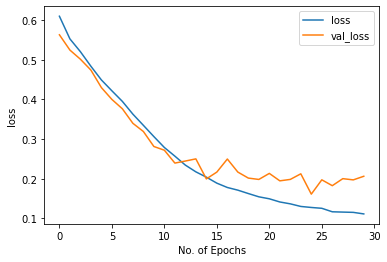

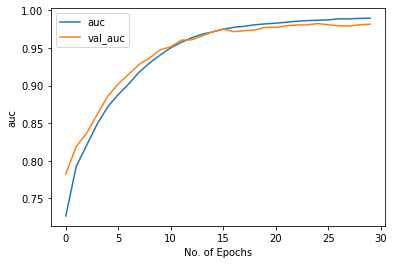

In [93]:
# recall fuction for plotting
plot_graphs(model8, "loss")
plot_graphs(model8, "auc")

**Observation**

After running the model I observed that the model perform very good and gave a very high accuracy and the model learnt very well as there is a small overfitting according to the plot of (loss & accuracy) which mean using GGNN aggregation mechanisms with ['hidden_dim'] = 64 has a very good effect on the model's performance.

In [94]:
# get the prediction values from predict model 
y_pred = model_8.predict(gen_batch(testing_set, batch_size=16, shuffle=False))
y_pred = np.reshape(y_pred, -1)
y_pred

array([2.3299754e-02, 1.9168216e-01, 9.6782798e-01, ..., 3.1421066e-06,
       2.7560698e-05, 9.9730313e-01], dtype=float32)

In [95]:
import pandas as pd 

submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_8.csv')

# Trial_9

**Thoughts and observations for trial 9, plan for trial 10**

**Thoughts**

I will build a GNN model to make a prediction based on our data (SDF file) with hyperparamters

* params["hidden_dim"] = 64

* params['dense_every_num_layers']=16

* params["message_calculation_class"] = 'RGCN'

I will build the model by adding Embedding layer to enables us to convert each word into a fixed length vector of defined size and adding a GNN input layer to encode data about the graph's structure.then uses this data to update the node and edge representations that were created at the start , adding dense(1,activation='sigmoid') as here we only output 1 probability and it is a binary classification

Here I used RGCN as an aggregation mechanisms in the graph convolution layer

R-GCN has been proposed as a multi-relational version of the GCN architecture and has shown state-of-the-art performance on standard knowledge graph completion tasks including entity classification and link prediction.[2]

**Expectation**

The model's performance will be very good and the model will learn well as using hyperparameters ["hidden_dim"] = 64, ['dense_every_num_layers']=16 and use the GNN with RGCN as an aggregation mechanisms models are very well suited to the type of data as R-GCN is defined over the multimodal graphs and it will appropiate to develop and evaluate the model in order to achieve the best prediction.

**Observation**

The model will learn and perform well and get high accuracy and may not happen overfitting or underfitting.

**Plan for Trial_10**

I will don't use any aggregation mechanisms that used in the graph convolution layer but use only hyperparameters  To find out its effect of didn't use any of aggregation mechanisms on the model performance.

In [84]:
# import libraries needed to build model 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.math import segment_mean

 #Input layer for nodes
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)     # Input layer for edge data    # edge is 2D 
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # Input layer for node2graph
embeded = Embedding(tokenizer.num_words, 20)(data)            # define embedding layer with each token embedded as size vector

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params['hidden_dim'] = 64   # hidden dimension of gnn layer 
params['dense_every_num_layers']=16
params["message_calculation_class"] = 'RGCN' # configures the message passing style using RGCN layer 
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)  # gnn output layer 

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(data=gnn_out,segment_ids=node2graph)  #calculating segmented mean based on segment_ids
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)        #binary classification: Dense(1), but here we only output 1 probability
print('pred:', pred)



model_9 = Model(
    #inputs are data,edges and node2graph
    inputs={   
        'data': data,
        'edges': edge,
        'node2grah': node2graph,},
    #output: prediction value from dense layer
    outputs=pred)
# print summary of model 
model_9.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_12/StatefulPartitionedCall:0', description="created by layer 'gnn_12'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_12/SegmentMean:0', description="created by layer 'tf.math.segment_mean_12'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_12/Sigmoid:0', description="created by layer 'dense_12'")
Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_37 (InputLayer)          [(None,)]            0           [] 

In [85]:
# compile model 
model_9.compile(loss='BinaryCrossentropy',metrics=['AUC'])

In [86]:
import math

batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size)               # number of batches for training data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)  # number of batches for validation data

# fit model 
model9=model_9.fit(gen_batch(training_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(validation_set, batch_size=32, repeat=True),
    validation_steps=num_batchs_validation)

Epoch 1/20
1265/1265 [==============================] - 57s 43ms/step - loss: 0.6258 - auc: 0.7072 - val_loss: 0.6068 - val_auc: 0.7415
Epoch 2/20
1265/1265 [==============================] - 54s 43ms/step - loss: 0.5946 - auc: 0.7468 - val_loss: 0.5962 - val_auc: 0.7559
Epoch 3/20
1265/1265 [==============================] - 52s 41ms/step - loss: 0.5803 - auc: 0.7643 - val_loss: 0.5688 - val_auc: 0.7806
Epoch 4/20
1265/1265 [==============================] - 53s 42ms/step - loss: 0.5627 - auc: 0.7826 - val_loss: 0.5608 - val_auc: 0.7999
Epoch 5/20
1265/1265 [==============================] - 51s 41ms/step - loss: 0.5426 - auc: 0.8023 - val_loss: 0.5224 - val_auc: 0.8233
Epoch 6/20
1265/1265 [==============================] - 53s 42ms/step - loss: 0.5253 - auc: 0.8168 - val_loss: 0.5257 - val_auc: 0.8228
Epoch 7/20
1265/1265 [==============================] - 55s 44ms/step - loss: 0.5148 - auc: 0.8256 - val_loss: 0.4979 - val_auc: 0.8396
Epoch 8/20
1265/1265 [==========================

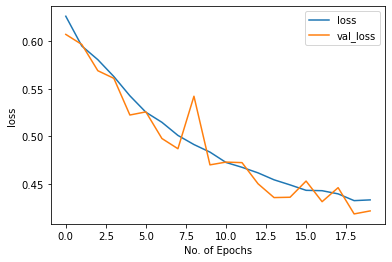

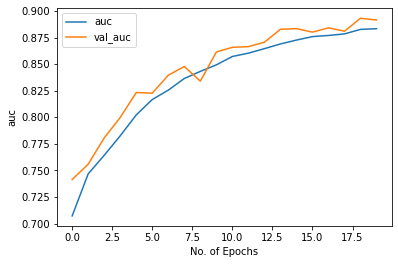

In [87]:
# recall function for plotting 
plot_graphs(model9, "loss")
plot_graphs(model9, "auc")

Observation

After running the model I observed that the model's performance was good as I expected the the model learned well as there is a little overfitting according to the plot of (loss & accuracy) which mean using RGCN aggregation mechanisms has a good effect on the model's performance because R-GCN is defined over the multimodal graphs and our data is (SDF) and we use graghical dataset consist of nodes and links.

In [96]:
# get the prediction values from predict model 
y_pred = model_9.predict(gen_batch(testing_set, batch_size=16, shuffle=False))
y_pred = np.reshape(y_pred, -1)
y_pred

array([0.9130295 , 0.14476168, 0.07798484, ..., 0.07032657, 0.65957457,
       0.43607056], dtype=float32)

In [97]:
import pandas as pd 

submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_9.csv')

# Trial_10

**Thoughts and observations for trial 10**

**Thoughts**

I will build a GNN model to make a prediction based on our data (SDF file) with hyperparamters

* params["hidden_dim"] = 64

* params['dense_every_num_layers']=16

I will build the model by adding Embedding layer to enables us to convert each word into a fixed length vector of defined size and adding a GNN input layer to encode data about the graph's structure. then uses this data to update the node and edge representations that were created at the start , adding dense(1,activation='sigmoid') as here we only output 1 probability and it is a binary classification

**Expectation**

The model's performance will be good and the model will learn well as using hyperparameters ["hidden_dim"] = 64, ['dense_every_num_layers']=16 and using the GNN models which are very well suited to the type of data used (SDF) to develop and evaluate the model in order to achieve the best prediction.

**Observation**

The model's performance will be good and may not happen overfitting or underfitting.

In [88]:
# import libraries needed to build model 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.math import segment_mean

 #Input layer for nodes
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)     # Input layer for edge data    # edge is 2D 
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # Input layer for node2graph
embeded = Embedding(tokenizer.num_words, 20)(data)            # define embedding layer

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 64   # hidden dimension of gnn layer
params['dense_every_num_layers']=16
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)  # gnn output layer 

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(data=gnn_out,segment_ids=node2graph)  #calculating segmented mean based on segment_ids
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)        #binary classification: Dense(1), here we only output 1 probability
print('pred:', pred)



model_10 = Model(
    #inputs are data,edges and node2graph
    inputs={   
        'data': data,
        'edges': edge,
        'node2grah': node2graph,},
    #output: prediction value from dense layer
    outputs=pred)
# print summary of model 
model_10.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_13/StatefulPartitionedCall:0', description="created by layer 'gnn_13'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_13/SegmentMean:0', description="created by layer 'tf.math.segment_mean_13'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_13/Sigmoid:0', description="created by layer 'dense_13'")
Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_42 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_40 (InputLayer)          [(None,)]            0           [] 

In [89]:
# compile model 
model_10.compile(loss='BinaryCrossentropy',metrics=['AUC'])

In [90]:
import math

batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size)               # number of batches for training data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)  # number of batches for validation data

# fit model 
model10=model_10.fit(gen_batch(training_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(validation_set, batch_size=32, repeat=True),
    validation_steps=num_batchs_validation)

Epoch 1/20
1265/1265 [==============================] - 55s 42ms/step - loss: 0.6230 - auc: 0.7074 - val_loss: 0.6093 - val_auc: 0.7363
Epoch 2/20
1265/1265 [==============================] - 56s 44ms/step - loss: 0.5937 - auc: 0.7468 - val_loss: 0.5831 - val_auc: 0.7608
Epoch 3/20
1265/1265 [==============================] - 56s 44ms/step - loss: 0.5797 - auc: 0.7639 - val_loss: 0.5766 - val_auc: 0.7765
Epoch 4/20
1265/1265 [==============================] - 53s 42ms/step - loss: 0.5652 - auc: 0.7807 - val_loss: 0.5555 - val_auc: 0.8007
Epoch 5/20
1265/1265 [==============================] - 52s 41ms/step - loss: 0.5468 - auc: 0.7999 - val_loss: 0.5381 - val_auc: 0.8173
Epoch 6/20
1265/1265 [==============================] - 52s 41ms/step - loss: 0.5278 - auc: 0.8158 - val_loss: 0.5132 - val_auc: 0.8307
Epoch 7/20
1265/1265 [==============================] - 53s 42ms/step - loss: 0.5122 - auc: 0.8285 - val_loss: 0.5234 - val_auc: 0.8346
Epoch 8/20
1265/1265 [==========================

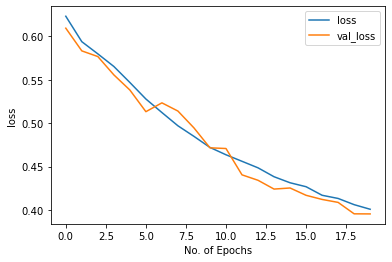

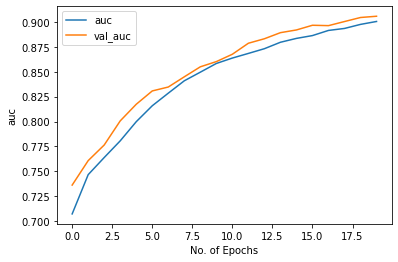

In [91]:
# recall function for plotting 
plot_graphs(model10, "loss")
plot_graphs(model10, "auc")

**Observation**

After running the model I observed that the model's performance was good as I expected the the model learned well as there is no overfitting or underfitting according to the plot of (loss & accuracy) and I observed that the model perform better when using GCN aggregation mechanisms as the model gives higher accuracy.

In [98]:
# get the prediction values from predict model 
y_pred = model_10.predict(gen_batch(testing_set, batch_size=16, shuffle=False))
y_pred = np.reshape(y_pred, -1)
y_pred

array([0.8815256 , 0.01402819, 0.09774867, ..., 0.03693816, 0.9062484 ,
       0.48329243], dtype=float32)

In [92]:
import pandas as pd 

submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_10.csv')

# Problem Formulation:

**Define the problem**

The problem is to predict a chemical compound's anticancer activity based on its chemical structure by using graph data.
which consist of chemical compound can be either positive or negative in its effects on lung cancer cells, and thus be labelled as 0 or 1 so it is a binary classification problem.

**What is the input?**

The input is a graph data (SDF file) which consist of chemical structure of the compound. Each sample of data contains atoms(nodes) and the connections between atoms of the molecule(linkes).

**What is the output?** 

The output is 0, 1 (0: has negative negative effects on lung cancer cells)(1:has positive effect on lung cancer cells.

**What data mining function is required?** 

Data mining function is a binary classification function.

**What could be the challenges?**

The challenges are

* We need to read dataset which is in (SDF) format and need a special way to read it (creating function from scratch) 

* The data was very unbalanced dataset and need to resample this data using (Up-sampling)

* Need to Build GNN model that can able to predict if the chemical compound has  positive or negative effect on lung cancer cells. 

* Try to improve the model's performance by applying GCN aggregation mechanisms and tuning the hyperparameters.

**What is the impact?**

The impact is when building the model that can be able to predict the  anticancer activity based on chemical compound this will be very usful for peaple's health (which mean peaple can able to predict if their lung cell is anticancer activity or not).

**What is an ideal solution?**

The ideal solution is when building the GNN model and using GGNN aggregation mechanisms. The model perform very well and gave very accuracy.

### What is the experimental protocol used and how was it carried out?
    
* Reading  the sdf file to get the information about the atoms and their connectivity in the compound. The atoms are represent nodes and connections represent  edges.  The read_sdf method is used to read sdf file


* The nodes(atoms) are given as characters (such as  ['H','O','N'....]). So we deal with it as sequence of text data and best way to describe the text data sequence to tokenize the data and then adding the embeddig layer.


* Graph convolutional network is used in this assignment to calculate the probability of the output class. We use different  message passing methods as:

 * GGNN: Gated Graph Neural Networks

 * RGCN: Relational Graph Convolutional Networks

 * RGAT: Relational Graph Attention Networks

 * RGIN: Relational Graph Isomorphism Networks
 
---

### How did we tune hyper-parameters in the template?

The Hyperparameters that are tuned in this template are "hidden_dim" , "dense_every_num_layers",  number of epochs, batch size, and size of the hold-out set for validation

---

### What is the search space and what is the criteria to determine good/bad hyper-parameters?

When solving a problem, we usually look for the best solution, among others. The space of all feasible solutions (the set of solutions in which the desired solution is located) is called the search space (also known as the state space).

The criteria to determine good/bad hyper-parametersis that the good hyperparameter will deliver the best performance metric or loss as measured on a validation set.

# The Questions: 

**1- Based on the provided template, describe the format of the input file (sdf file)**

The input file is structure data file (SDF).It contains information on a molecule's chemical composition.

SDF files include information about the positions of individual atoms in a chemical molecule as well as the connections between them. 
The expression 'dolar sign' separates between different compounds.

Each molecule begins with a header that contains the compound's name. Other sections include details on the amount of Atoms, the version number, and connections, among other things. The constituents of the compound are described in the atom block. The bond block block describes the compound's bonding structure. Both of these blocks are utilised in this assignment to obtain information about the compound and save it as edges and nodes. Each node represents an atom in a chemical compound.

---

**2- What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size)?**

The input tensors to the neural network model are **data, edge and node2graph**

**data** The data contains the chemical compound's nodes, each node for the compound are extracted, then tokenized  with tokenizer and padded with the pad sequence method.

**data dims** The shape for each batch is **[batch_size*max_len_nodes]** where batch_size is the number of samples in the batch and max_len_nodes is the length of tokenized nodes after apply padding.

**edges** Which carries information about atom connections (links between atoms).

**edges dims** The shape of edge is **[sum_of_all_edges,2]** which mean number of edges of each sample of the batch_size. 

**node2graph** This input contains information about segmented ids and is used for segmented mean.

**node2graph dims** The shape for each batch is **[batch_size*max_len_nodes]** where batch_size is the number of samples in the batch and max_len_nodes is the length of tokenized nodes after apply padding 

---

**3- For each dim of gnn_out, what does it symbolize? For each dim of avg, what does it symbolize?**

**gnn_out dims** The shape of gnn_out is **[batch_size_node_dimension,hidden layers]** where batch_size_node_dimension is the dimension of the input data (node) vector (dimension of tokenized vector for the complete batch).

It symbolize the aggregation output of the model for each hidden layer.

**avg** The shape of avg is **[batch_size, hidden_layer]**  it is for the final output of the avg

**avg** It is a way of collecting information for each sample and representing it in the form of mean data,and it takes the segmented mean of the gnn_out based on the segmented ids

---
**4- What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it symbolize?**

**The difference between segment_mean and tf.reduce_mean is that**
**segment_mean** calculate mean of the data which have same segmented ids and **reduce_mean** calculate  mean of elements across dimensions of a given the arguments.

**pred** Is the output (pred) which explain the probability of a chemical compound to be active for the cancer cell or not.

The shape of pred is [batch_size,1]. for each sample, the output is  number which represents the probability of each chemical compound.

---

**5- What is the motivation/theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?** 

**The idea to use multiple gcn layers** helps to properly incorporate all graph complexity, resulting in a better model.

**The layers were used in the template** The default layer are 4 as given in the documentaion. The default message passing method is rgcn (Graph convolution layers)



# References

[1] https://cnvrg.io/graph-neural-networks/

[2] http://snap.stanford.edu/class/cs224w-2019/project/26223353.pdf

[3] https://arxiv.org/abs/2109.05922#:~:text=Graph%20Attention%20Network%20(GAT)%20focuses,(e.g.%2C%20knowledge%20graphs).

[4] https://www.researchgate.net/publication/342573754_Understanding_Graph_Isomorphism_Network_for_rs-fMRI_Functional_Connectivity_Analysis